## Loading model checkpoints

Once a model is trained, a corresponding model checkpoint (eg. `checkpoint-99.pth`) is saved in `output_dir` along with the `args.json` that contains the command line arguments for the training run.

This notebook shows how to load a model checkpoint and generate a few snapshots.

In [1]:
from pathlib import Path
import json
from models.model_configs import instantiate_model
import torch
from training.eval_loop import CFGScaledModel
from flow_matching.path import MixtureDiscreteProbPath
from flow_matching.path.scheduler import PolynomialConvexScheduler
from flow_matching.solver.ode_solver import ODESolver
from flow_matching.solver.discrete_solver import MixtureDiscreteEulerSolver
from matplotlib import pyplot as plt

### [Meta Only] Pretrained checkpoints


| Model    | FID |
| -------- | ----|
| Cifar10, unconditional | 2.07 |
| Imagenet32, face-blurred, conditional  | 1.14 |
| Imagenet64, face-blurred, conditional  | 1.68 |
| Cifar10, discrete flow matching, unconditional  | 3.58 |

In [2]:
# Substitute your pretrained checkpoint path
checkpoint_path = Path("/path/to/checkpoint.pth")
args_filepath = checkpoint_path.parent / 'args.json'
with open(args_filepath, 'r') as f:
    args_dict = json.load(f)

model = instantiate_model(architechture=args_dict['dataset'], is_discrete='discrete_flow_matching' in args_dict  and args_dict['discrete_flow_matching'],
                          use_ema=args_dict['use_ema'])
checkpoint = torch.load(checkpoint_path, map_location="cpu")
model.load_state_dict(checkpoint["model"])
model.train(False)

device = 'cuda'
model.to(device=device)

# Set the sampling resolution corresponding to the model
if 'train_blurred_64' in args_dict['data_path'] and args_dict['dataset'] == 'imagenet':
    sample_resolution = 64
elif 'train_blurred_32' in args_dict['data_path'] or args_dict['dataset'] == 'cifar10':
    sample_resolution = 32

batch_size = args_dict['batch_size']


## Sampling

In [3]:
# Generate from classes 1,2,..,batch_size - 1
labels = torch.tensor(list(range(batch_size)), dtype=torch.int32, device=device)

cfg_weighted_model = CFGScaledModel(model=model)

if 'discrete_flow_matching' in args_dict and args_dict['discrete_flow_matching']:
    if 'sym_func' in args_dict and args_dict['sym_func']:
        sym = lambda t: 12.0 * torch.pow(t, 2.0) * torch.pow(1.0 - t, 0.25)
    else:
        sym = args_dict['sym']
    path = MixtureDiscreteProbPath(scheduler=PolynomialConvexScheduler(n=3.0))
    p = torch.zeros(size=[257], dtype=torch.float32, device=device)
    p[256] = 1.0
    solver = MixtureDiscreteEulerSolver(model=cfg_weighted_model, path=path, vocabulary_size=257, p=p)
    x_0 = torch.zeros([batch_size, 3, sample_resolution, sample_resolution], dtype=torch.long, device=device) + 256
    synthetic_samples = solver.sample(
        x_init=x_0,
        step_size=1.0 / args_dict['discrete_fm_steps'],
        verbose=False,
        div_free=sym,
        dtype_categorical=torch.float32,
        label=labels,
        cfg_scale=args_dict['cfg_scale'],
    )
else:
    x_0 = torch.randn([batch_size, 3, sample_resolution, sample_resolution], dtype=torch.float32, device=device)    
    solver = ODESolver(velocity_model=cfg_weighted_model)
    ode_opts = args_dict['ode_options']
    ode_opts["method"] = args_dict['ode_method']
    synthetic_samples = solver.sample(
        time_grid=torch.tensor([0.0, 1.0], device=device),
        x_init=x_0,
        method=args_dict['ode_method'],
        atol=args_dict['ode_options']['atol'] if 'atol' in args_dict['ode_options'] else None,
        rtol=args_dict['ode_options']['rtol'] if 'rtol' in args_dict['ode_options'] else None,
        step_size=args_dict['ode_options']['step_size'] if 'step_size' in args_dict['ode_options'] else None,
        label=labels,
        cfg_scale=args_dict['cfg_scale'],
    )

    # Scaling to [0, 1] from [-1, 1]
    synthetic_samples = torch.clamp(
        synthetic_samples * 0.5 + 0.5, min=0.0, max=1.0
    )
    synthetic_samples = torch.floor(synthetic_samples * 255) / 255.0

## Plotting the samples

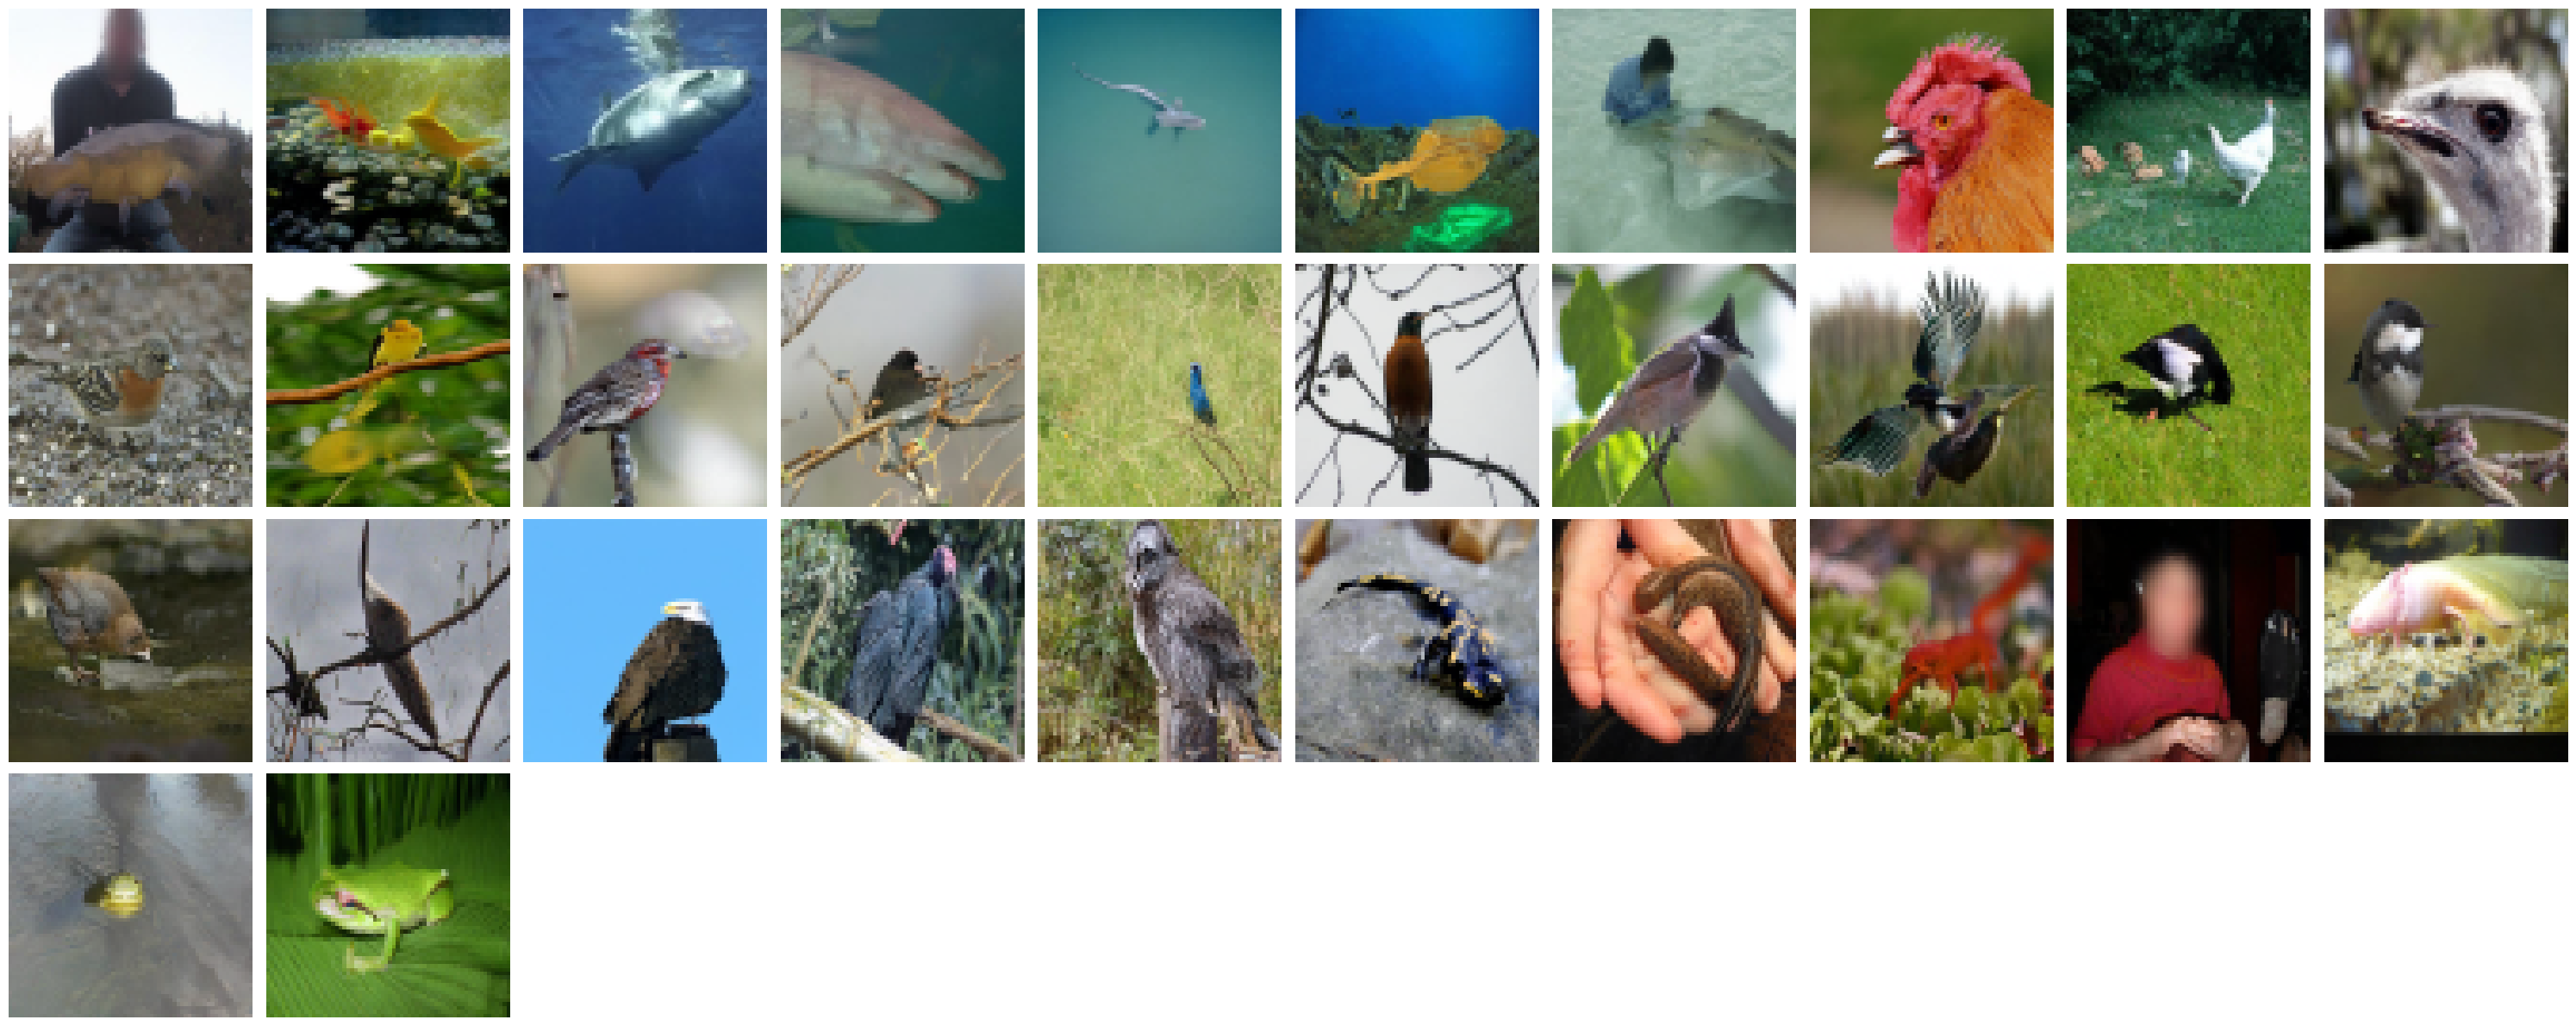

In [4]:
cols = 10
rows = (batch_size + cols - 1) // cols
plt.figure(figsize=(cols * 3, rows * 3))
for i in range(batch_size):
    image = synthetic_samples[i].cpu().permute(1, 2, 0).numpy()
    plt.subplot(rows, cols, i + 1)
    plt.imshow(image)
    plt.axis('off')
plt.tight_layout()
plt.show()